In [4]:
import os
import sys
import random
import warnings
import cv2
import time
import numpy as np

import matplotlib.pyplot as plt
import glob
from tqdm import tqdm          ## 顯示進度條
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.preprocessing.image import array_to_img
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
## 使用GPU
from keras import backend as K
K.tensorflow_backend._get_available_gpus()



# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = glob.glob('./DataAndMask/Original/*.png')
TRAIN_MASK = './DataAndMask/label/'
TEST_PATH = glob.glob('./New/LIP/TrainVal_images/TrainVal_images/val_images/*.jpg')
TEST_MASK = './New/LIP/TrainVal_parsing_annotations/TrainVal_parsing_annotations/val_segmentations/'

# seed = 42
# random.seed = seed
# np.random.seed = seed

Using TensorFlow backend.


In [ ]:
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

In [ ]:
## 用來將檔案內的 Image 或 Mask 寫入 TXT 檔案，會將 Image & Mask 做對應
## ImagePath : 圖片全路徑
## MaskPath : 遮罩資料夾路徑
## saveName : 要存的 TXT 名稱
## typeMask : 遮罩圖片的副檔名           
def txtWriter(ImagePath, MaskPath, saveName, typeMask='.png'):
    with open(saveName + '.txt', 'w') as f:
        for name in ImagePath:
            fileName = os.path.splitext(name)[0]
            fileName = fileName.split('/')[-1]
            f.write(name + ' ' + MaskPath + fileName + typeMask + '\n') 
ab = glob.glob('./test_data/images/*.jpeg')
bb = './test_data/label/'
txtWriter(ab, bb, './test_data/Train', '.jpg')
# txtWriter(TRAIN_PATH, TRAIN_MASK, './DataAndMask/Train')

In [ ]:
# f = open('./test_data/Train_png.txt', 'r')
# items = f.readlines()
# f = open('./test_data/Train.txt', 'r')
# items_ = f.readlines()
# f = open('./humanparsing/Train_Seg.txt', 'r')
# items_seg = f.readlines()
# a = items_seg + items_ + items
# with open('./humanparsing/TestHuman' + '.txt', 'w') as f:
#     for name in a:
#         f.write(name)

In [ ]:
############################## 多筆資料要做訓練時，藉由此函式讀取資料並搭配 keras 的 fit_generate ##############################
## 隨機生成 Image & Mask
## txtFile : TXT 檔案路徑
## batch_size : batch 大小
## IMAGW_WIDTH : 圖片寬度
## IMAGW_HEIGHT : 圖片高度
def generate_data(txtFile, batch_size, IMAGE_WIDTH, IMAGE_HEIGHT):
    """Replaces Keras' native ImageDataGenerator."""
    f = open(txtFile, 'r')
    items = f.readlines()
    i = 0
    while True:
#         image_batch = []
#         label_batch = []
        image_batch = np.zeros((batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=np.float32)
        label_batch = np.zeros((batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)
        for b in range(batch_size):
            mask = np.zeros((IMAGE_WIDTH, IMAGE_HEIGHT, 1), dtype=np.bool)
            if i == len(items)//batch_size:
                i = 0
                random.shuffle(items)
            sample = items[i]
            image_path = sample.split(' ')[0]                   ## 以空白部分分開兩段  [xxx xxx]
            label_path = sample.split(' ')[-1].strip()          ## 去掉後面 \n
            #### 圖片處理
            image = cv2.resize(cv2.imread(image_path), (IMAGE_WIDTH, IMAGE_HEIGHT), 
                               interpolation=cv2.INTER_CUBIC)
            image_batch[b] = image.astype(np.float32) / 255.0
            ### 遮罩處理
            label = cv2.imread(label_path)
            label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
            label = cv2.resize(label,(IMAGE_WIDTH,IMAGE_HEIGHT), interpolation=cv2.INTER_CUBIC)
#             b, label = cv2.threshold(label, 0, 255, cv2.THRESH_BINARY)   ## 進行二值化，使目標物變成白色
#             label = label.astype(np.float32) / 255.0
            label = np.expand_dims(label, axis=-1)
            mask = np.maximum(mask, label)
            label_batch[b] = mask
            i += 1
        yield image_batch, label_batch


In [ ]:
### 導入全部 data & label
### imgPath : 所有圖片列表
### maskFolder : 遮罩資料夾
### IMAGE_HEIGHT : 欲調整圖片之高
### IMAGE_WIDTH :欲調整圖片之寬
def load_data(imgPath, maskFolder, IMAGE_HEIGHT, IMAGE_WIDTH):
    print('Getting and resizing image & masks ...')
    sys.stdout.flush()
    image_batch = np.zeros((len(imgPath), IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=np.float32)
    label_batch = np.zeros((len(imgPath), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)
    
    for i, trainPath in tqdm(enumerate(imgPath), total=len(imgPath)):
        mask = np.zeros((IMAGE_WIDTH, IMAGE_HEIGHT, 1), dtype=np.bool)
        image = cv2.resize(cv2.imread(trainPath), (IMAGE_WIDTH, IMAGE_HEIGHT), 
                           interpolation=cv2.INTER_CUBIC)
        image_batch[i] = image.astype(np.float32) / 255.0
        
        labelPath = os.path.splitext(trainPath)[0]
        labelPath = maskFolder + labelPath.split('/')[-1] + '.png'
        ### 遮罩處理
        label = cv2.imread(labelPath)
        label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
        label = cv2.resize(label,(IMAGE_WIDTH,IMAGE_HEIGHT), interpolation=cv2.INTER_CUBIC)
        b, label = cv2.threshold(label, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)   ## 進行二值化，使目標物變成白色
#             label = label.astype(np.float32) / 255.0
        label = np.expand_dims(label, axis=-1)
        mask = np.maximum(mask, label)
        label_batch[i] = mask
    print(image_batch.shape, label_batch.shape)
    return image_batch, label_batch

In [2]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

## 使用 U-net 架構
<img src="./jupyter image/U-net.png">

Reference code: https://github.com/SixQuant/U-Net/blob/master/kernel.ipynb


In [ ]:
def UnetModel(pretrained_model = None, input_size = (IMG_WIDTH, IMG_HEIGHT, 3)):
    "This is a UnetModel-RGB to Remvoe Background"
    inputs = Input(input_size)

    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6])
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7])

    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8])

    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9])
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)


    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=[mean_iou])
    
    if(pretrained_model):
        model.load_model(pretrained_model)
    
    model.summary()
    return model

## 使用 U-net like 架構
<img src="./jupyter image/architecture.png">


Reference : https://hackernoon.com/releasing-supervisely-person-dataset-for-teaching-machines-to-segment-humans-1f1fc1f28469

In [ ]:
def UnetModel_Modify(pretrained_model = None, input_size = (IMG_WIDTH, IMG_HEIGHT, 3)):
    "This is a UnetModel-RGB to Remvoe Background"
    inputs = Input(input_size)

    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal', dilation_rate=(2, 2))(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal', dilation_rate=(2, 2))(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6])
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7])

    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8])

    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9])
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)


    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=[mean_iou])
    
    if(pretrained_model):
        model.load_model(pretrained_model)
    
    model.summary()
    return model

In [ ]:
train = generate_data('./humanparsing/TestHuman.txt', 16, IMG_WIDTH, IMG_HEIGHT)
# val = generate_data('./Test.txt', 16, IMG_WIDTH, IMG_HEIGHT)

# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('./humanparsing/model-person_testSeg.h5', monitor='loss', verbose=1, save_best_only=True)

# results = model.fit(trainX, trainY, validation_split=0.2, batch_size=2, epochs=50, 
#                     callbacks=[checkpointer], verbose=1, shuffle=True)

# results = model.fit(X_train_part, Y_train_part, validation_data=(X_test_part, Y_test_part), batch_size=32, epochs=50, 
#                     callbacks=[checkpointer], verbose=1, shuffle=True)
model = UnetModel()
result = model.fit_generator(train,
                        steps_per_epoch=  17808 // 16,
#                         validation_data=val,
#                         validation_steps=5000 // 16,
                        epochs=50,
                        callbacks=[checkpointer])


In [ ]:
fig = plt.figure(figsize=(15,10), dpi=300)
plt.plot(result.history['mean_iou'])
plt.plot(result.history['loss'])
plt.legend(['mean_iou', 'loss'], fontsize=18)
plt.xlabel('epochs')
plt.ylabel('percent')
plt.title('U-net_RGB', fontsize=15)
plt.savefig('./humanparsing/model-person_testSeg.png')


In [ ]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('./humanparsing/modelModify-person_testSeg.h5', monitor='loss', verbose=1, save_best_only=True)

train = generate_data('./humanparsing/TestHuman.txt', 8, IMG_WIDTH, IMG_HEIGHT)

# results = model.fit(trainX, trainY, validation_split=0.2, batch_size=2, epochs=50, 
#                     callbacks=[checkpointer], verbose=1, shuffle=True)

# results = model.fit(X_train_part, Y_train_part, validation_data=(X_test_part, Y_test_part), batch_size=32, epochs=50, 
#                     callbacks=[checkpointer], verbose=1, shuffle=True)
model_modify = UnetModel_Modify()
result_modify = model_modify.fit_generator(train,
                        steps_per_epoch=  1000,
#                         validation_data=val,
#                         validation_steps=5000 // 16,
                        epochs=50,
                        callbacks=[checkpointer])

In [5]:
##   將原圖與預測出來的遮罩合併在一起，去掉背景
##   imgPath : 圖片路徑
##   model : 訓練完的模型
def removeBackground(imgPath, model):
    imgOrg = cv2.imread(imgPath)
    width, height = imgOrg.shape[:2]
    img = cv2.resize(imgOrg, (256, 256))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    mask = model.predict(img)
    mask = (mask > 0.5).astype(np.uint8)                    ### 因為 sigmoid 結果為 0~1 之間，所以要取一半作為臨界值
    mask = np.squeeze(mask)                                 #### 將 mask 降維   (256,256,1) -> (256,256)
    mask = cv2.resize(mask, (height, width), interpolation=cv2.INTER_CUBIC)
    b,g,r = cv2.split(imgOrg)       # get b,g,r
    imgOrg = cv2.merge([r,g,b])     # switch it to rgb
    remove = cv2.bitwise_and(imgOrg, imgOrg, mask= mask)
    plt.figure(figsize=(15,15))
    plt.subplot(121)
    plt.grid(False)
    plt.imshow(imgOrg)
    plt.subplot(122)
    plt.grid(False)
    plt.imshow(remove)


## 以不同資料再次訓練

In [6]:
## Different data 
PreTrainPath = glob.glob('./DataAndMask/Original/*.png')
PreMaskPath = './DataAndMask/label/'
preTrain, preMask = load_data(PreTrainPath, PreMaskPath, IMG_HEIGHT, IMG_WIDTH)

In [ ]:
### 資料增強
from keras.preprocessing import image
seed = 40
# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

# Keep the same seed for image and mask generators so they fit together

image_datagen.fit(preTrain, augment=True, seed=seed)
mask_datagen.fit(preMask, augment=True, seed=seed)

x = image_datagen.flow(preTrain, batch_size=16, shuffle=True, seed=seed)
y = mask_datagen.flow(preMask, batch_size=16, shuffle=True, seed=seed)
train_generator = zip(x, y)

In [ ]:
# checkpointer = ModelCheckpoint('./humanparsing/model-person_fewData.h5', monitor='loss', verbose=1, save_best_only=True)
checkpointer = ModelCheckpoint('./humanparsing/Weight/model-person_seg_again.h5', monitor='loss', verbose=1, save_best_only=True)
history = model.fit_generator(train_generator,
                        steps_per_epoch=  80,
#                         validation_data=val,
#                         validation_steps=5000 // 16,
                        epochs=50,
                        callbacks=[checkpointer])

#### Loading Model 

In [8]:
model = load_model('./humanparsing/Weight/modelModify-person_testSeg.h5', custom_objects={'mean_iou': mean_iou})

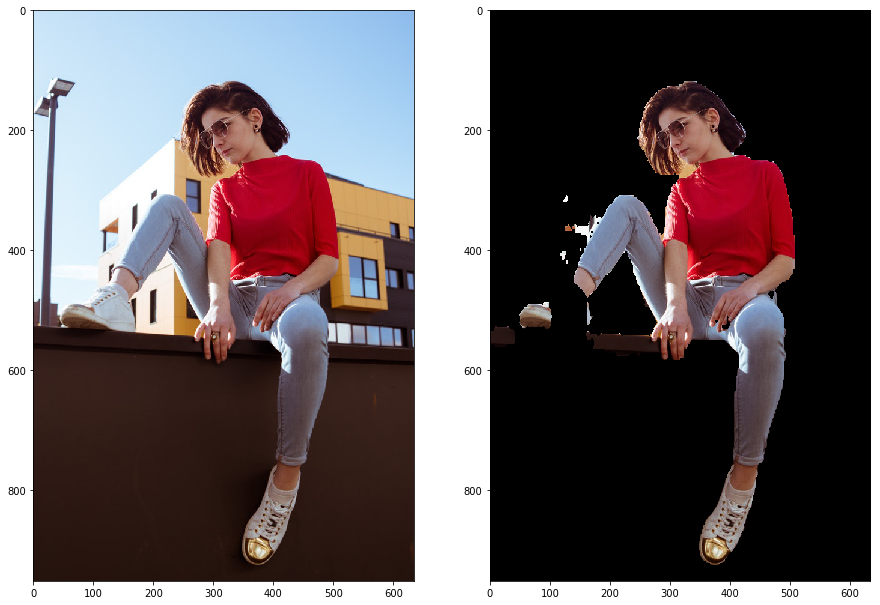

In [9]:
removeBackground('./test_data/images/11.jpeg', model)

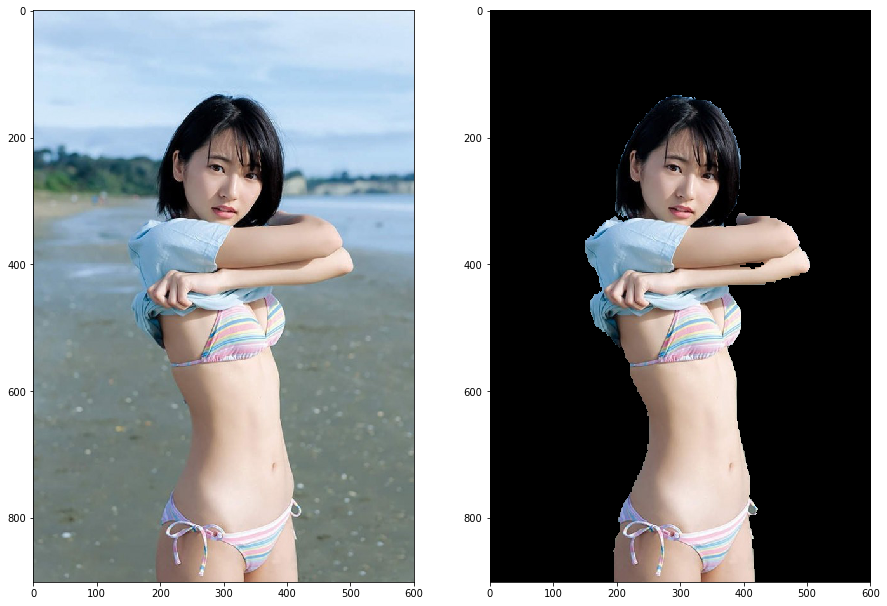

In [11]:
removeBackground('./test_data/valImg/600_phpSIU2LC.jpg', model)